In [25]:
import numpy as np
import matplotlib.pyplot as plt
import wave
from scipy.linalg import toeplitz
from scipy.io.wavfile import write
import IPython.display as ipd

In [26]:
def read_audio(path):
    signal = wave.open(path, 'rb')
    signal_data = signal.readframes(-1)
    signal_data = np.frombuffer(signal_data, dtype='int16')
    return signal_data, signal.getframerate()

In [27]:
def prep(signal, P):
    N = len(signal)
    corr = np.correlate(signal, signal, mode='full')[N-1:]
    corr = corr/(N-P+1)
    corr_vec = corr[P:2*P]
    R = toeplitz(corr_vec)
    return R, corr_vec, corr

In [28]:
def train(Rx, corr_vec):
    wopt = np.linalg.inv(Rx) @ corr_vec
    return wopt

In [29]:
def process(signal, wopt):
    N = len(signal)
    y = np.zeros(N)
    for i in range(P, N):
        y[i] = wopt @ signal[i-P:i]
    return y

In [30]:
def export_audio(filename, signal, fs):
    audio = signal.astype('int16')
    write('./audio/'+filename+'.wav', fs, audio)
    print('Audio exported successfully!')

In [124]:
def EQM(signal, y):
    return np.mean((signal-y)**2)

In [267]:
signal1, fs1 = read_audio('./audio/conv1.wav')
signal2, fs2 = read_audio('./audio/conv73.wav')

In [268]:
N = min(len(signal1), len(signal2))
signal1 = signal1[:N]
signal2 = signal2[:N]
signal = signal1 + signal2

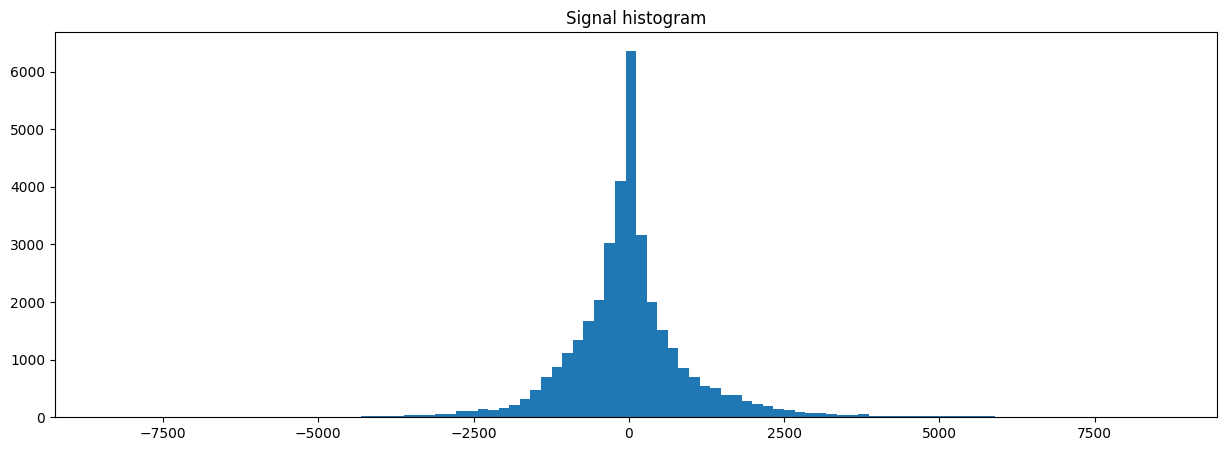

In [269]:
plt.figure(figsize=(15, 5))
plt.hist(signal, bins=100)
plt.title('Signal histogram')
plt.show()

In [270]:
frame_size = 256
hop_size = 128
P = 3

n_frames = int(np.floor((N/frame_size)*(frame_size/hop_size)-1))
whole_frames = int(np.floor(N/frame_size))

signal1 = signal1[:whole_frames*frame_size]
signal2 = signal2[:whole_frames*frame_size]
signal = signal[:whole_frames*frame_size]

signal1_frames = [signal1[i*hop_size:i*hop_size+frame_size] for i in range(n_frames-1)]
signal2_frames = [signal2[i*hop_size:i*hop_size+frame_size] for i in range(n_frames-1)]
signal_frames = [signal[i*hop_size:i*hop_size+frame_size] for i in range(n_frames-1)]

n_frames = n_frames - 1

wopt1_frames = np.zeros((n_frames, P))
wopt2_frames = np.zeros((n_frames, P))

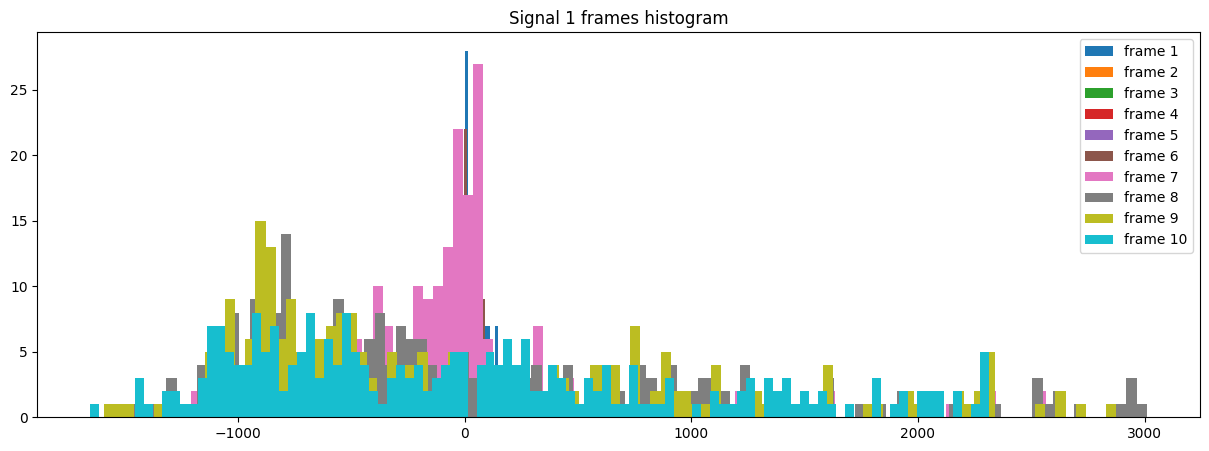

In [271]:
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.hist(signal1_frames[i], bins=100)
plt.title('Signal 1 frames histogram')
plt.legend(['frame '+str(i + 1) for i in range(10)])

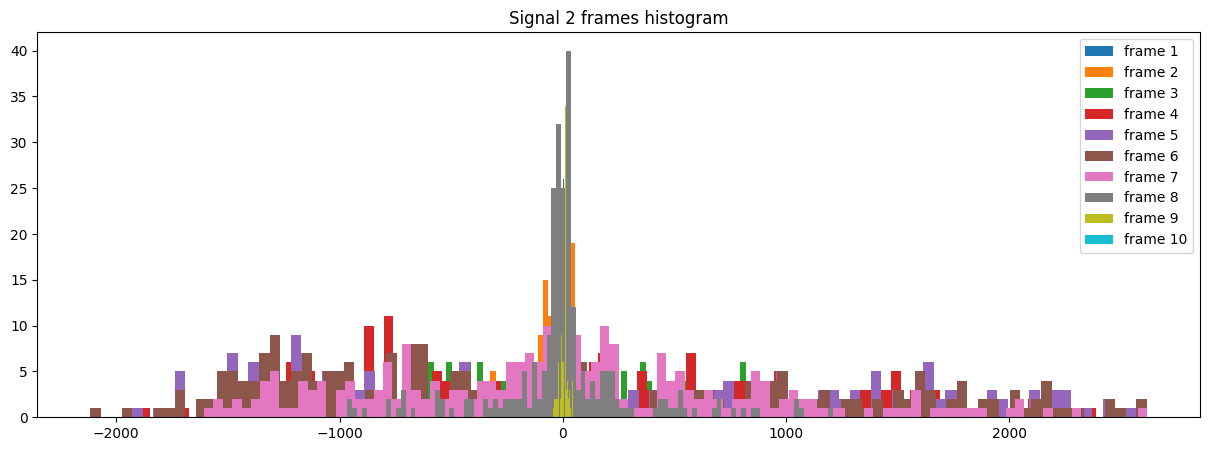

In [272]:
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.hist(signal2_frames[i], bins=100)
plt.title('Signal 2 frames histogram')
plt.legend(['frame '+str(i + 1) for i in range(10)])

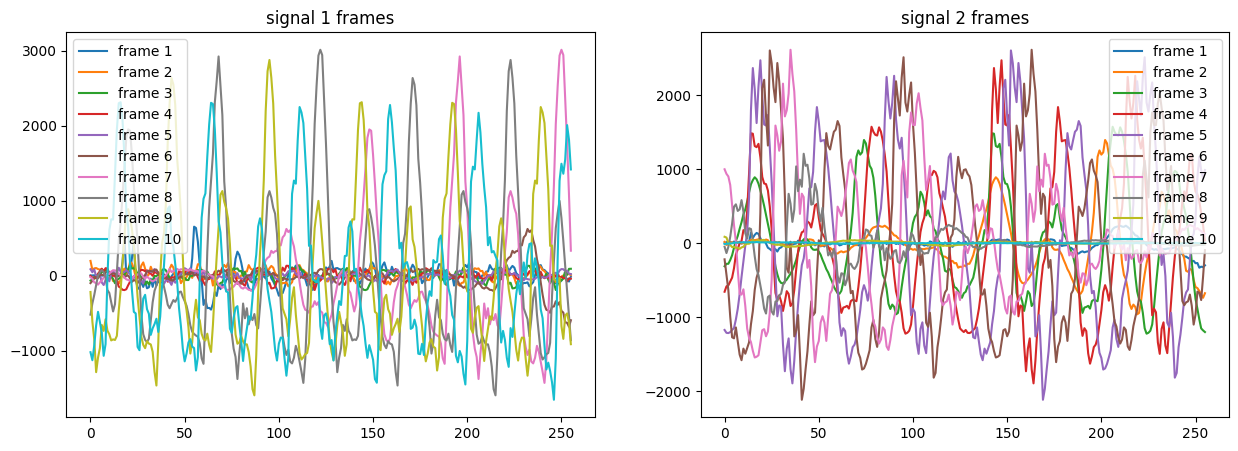

In [273]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
for i in range(10):
    plt.plot(signal1_frames[i])
plt.title("signal 1 frames")
plt.legend(['frame '+str(i + 1) for i in range(10)])

plt.subplot(1, 2, 2)
for i in range(10):
    plt.plot(signal2_frames[i])
plt.title("signal 2 frames")
plt.legend(['frame '+str(i + 1) for i in range(10)])

In [274]:
for i in range(n_frames):
    frame1 = signal1_frames[i]
    frame2 = signal2_frames[i]
    R1, corr_vec1, corr1 = prep(frame1, P)
    R2, corr_vec2, corr2 = prep(frame2, P)
    wopt1_frames[i] = train(R1, corr_vec1)
    wopt2_frames[i] = train(R2, corr_vec2)

In [275]:
d1hat_frames = np.zeros((n_frames, frame_size))
d2hat_frames = np.zeros((n_frames, frame_size))

for i in range(n_frames):
    frame = signal_frames[i]
    d1hat_frames[i] = process(frame, wopt1_frames[i])
    d2hat_frames[i] = process(frame, wopt2_frames[i])

In [276]:
d1hat = np.zeros(N) 
d2hat = np.zeros(N)

for i in range(n_frames):
    d1hat[i*hop_size:i*hop_size+frame_size] = d1hat_frames[i]
    d2hat[i*hop_size:i*hop_size+frame_size] = d2hat_frames[i]

In [280]:
SNR1_ap_db = 10*np.log10(np.sum(signal1**2)/np.sum((signal2)**2))
SNR2_ap_db = 10*np.log10(np.sum(signal2**2)/np.sum((signal1)**2))

In [282]:
print('SNR1_ap_db: ', SNR1_ap_db)
print('SNR2_ap_db: ', SNR2_ap_db)

SNR1_ap_db:  -0.10509313477560589
SNR2_ap_db:  0.10509313477560556


In [284]:
n_eqm1 = min(len(signal1), len(d1hat))
n_eqm2 = min(len(signal2), len(d2hat))

eqm1 = EQM(signal1[:n_eqm1], d1hat[:n_eqm1])
eqm2 = EQM(signal2[:n_eqm2], d2hat[:n_eqm2])

In [285]:
print('EQM1: ', eqm1)
print('EQM2: ', eqm2)

EQM1:  1239299.0243240243
EQM2:  1386356.9671708771


In [241]:
export_audio('d1hat_frames', d1hat, fs1)
export_audio('d2hat_frames', d2hat, fs2)

Audio exported successfully!
Audio exported successfully!


In [242]:
display(ipd.Audio(d1hat, rate=fs1))

In [243]:
N1 = min(len(d2hat), len(signal))
d2hat = d2hat[:N1]
signal = signal[:N1]

In [244]:
x1 = signal - d2hat

In [245]:
R1, corr_vec1, corr1 = prep(x1, P)
wopt = train(R1, corr_vec1)

In [246]:
d1hat1 = process(x1, wopt)

In [247]:
display(ipd.Audio(d1hat1, rate=fs1))